In [1]:
# Initialize OK
from client.api.notebook import Notebook
ok = Notebook('proj2.ok')

Assignment: proj2
OK, version v1.13.11



# Data 100 - Project 2: Spam/Ham Classification
## Feature Engineering, Logistic Regression, Cross Validation

## This Assignment
In this project, you will use what you've learned in class to create a classifier that can distinguish spam (junk or commercial or bulk) emails from ham (non-spam) emails. In addition to providing some skeleton code to fill in, we will evaluate your work based on your model's accuracy and your written responses in this notebook.

Some tasks in this prject will include:

- Feature engineering with text data
- Using sklearn libraries to process data and fit models
- Validating the performance of your model and minimizing overfitting
- Generating and analyzing precision-recall curves

# Part I - Initial Analysis

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

### Loading in the Data

In email classification, our goal is to classify emails as spam or not spam (referred to as "ham") using features generated from the text in the email. 

The dataset consists of email messages and their labels (0 for ham, 1 for spam). Your labeled training dataset contains 8348 labeled examples, and the test set contains 1000 unlabeled examples.

Run the following cells to load in the data into DataFrames.

The `train` DataFrame contains labeled data that you will use to train your model. It contains four columns:

1. `id`: An identifier for the training example
1. `subject`: The subject of the email
1. `email`: The text of the email
1. `spam`: 1 if the email is spam, 0 if the email is ham (not spam)

The `test` DataFrame contains 1000 unlabeled emails. You will predict labels for these emails and submit your predictions to Kaggle for evaluation.

In [3]:
from utils import fetch_and_cache_gdrive
fetch_and_cache_gdrive('1SCASpLZFKCp2zek-toR3xeKX3DZnBSyp', 'train.csv')
fetch_and_cache_gdrive('1ZDFo9OTF96B5GP2Nzn8P8-AL7CTQXmC0', 'test.csv')

original_training_data = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Convert the emails to lower case as a first step to processing the text
original_training_data['email'] = original_training_data['email'].str.lower()
test['email'] = test['email'].str.lower()

original_training_data.head()


Using version already downloaded: Mon Nov 18 11:52:38 2019
MD5 hash of file: 0380c4cf72746622947b9ca5db9b8be8
Using version already downloaded: Mon Nov 18 11:52:40 2019
MD5 hash of file: a2e7abd8c7d9abf6e6fafc1d1f9ee6bf


,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


### Question 1a
First, let's check if our data contains any missing values. Fill in the cell below to print the number of NaN values in each column. If there are NaN values, replace them with appropriate filler values (i.e., NaN values in the `subject` or `email` columns should be replaced with empty strings). Print the number of NaN values in each column after this modification to verify that there are no NaN values left.

Note that while there are no NaN values in the `spam` column, we should be careful when replacing NaN labels. Doing so without consideration may introduce significant bias into our model when fitting.

*The provided test checks that there are no missing values in your dataset.*

<!--
BEGIN QUESTION
name: q1a
points: 1
-->

In [4]:
original_training_data['subject'].fillna("", inplace=True)
original_training_data.isna().sum()

id         0
subject    0
email      0
spam       0
dtype: int64

In [5]:
ok.grade("q1a");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



### Question 1b

In the cell below, print the text of the first ham and the first spam email in the original training set.

*The provided tests just ensure that you have assigned `first_ham` and `first_spam` to rows in the data, but only the hidden tests check that you selected the correct observations.*

<!--
BEGIN QUESTION
name: q1b
points: 1
-->

In [6]:
first_ham = original_training_data[original_training_data['spam'] == 0].iloc[0]["email"]
first_spam = original_training_data[original_training_data['spam'] == 1].iloc[0]["email"]
print(first_ham)
print(first_spam)

url: http://boingboing.net/#85534171
 date: not supplied
 
 arts and letters daily, a wonderful and dense blog, has folded up its tent due 
 to the bankruptcy of its parent company. a&l daily will be auctioned off by the 
 receivers. link[1] discuss[2] (_thanks, misha!_)
 
 [1] http://www.aldaily.com/
 [2] http://www.quicktopic.com/boing/h/zlfterjnd6jf
 
 

<html>
 <head>
 </head>
 <body>
 <font size=3d"4"><b> a man endowed with a 7-8" hammer is simply<br>
  better equipped than a man with a 5-6"hammer. <br>
 <br>would you rather have<br>more than enough to get the job done or fall =
 short. it's totally up<br>to you. our methods are guaranteed to increase y=
 our size by 1-3"<br> <a href=3d"http://209.163.187.47/cgi-bin/index.php?10=
 004">come in here and see how</a>
 </body>
 </html>
 
 
 



In [7]:
ok.grade("q1b");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



### Question 1c

Discuss one thing you notice that is different between the two emails that might relate to the identification of spam.

<!--
BEGIN QUESTION
name: q1c
manual: True
points: 2
-->
<!-- EXPORT TO PDF -->

*One thing I noticed that is different between the two emails is that the spam email text is displayed as html response content whereas the ham email is in normal text.*

## Training Validation Split
The training data we downloaded is all the data we have available for both training models and **validating** the models that we train.  We therefore need to split the training data into separate training and validation datsets.  You will need this **validation data** to assess the performance of your classifier once you are finished training. Note that we set the seed (random_state) to 42. This will produce a pseudo-random sequence of random numbers that is the same for every student. **Do not modify this in the following questions, as our tests depend on this random seed.**

In [8]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(original_training_data, test_size=0.1, random_state=42)

# Basic Feature Engineering

We would like to take the text of an email and predict whether the email is ham or spam. This is a *classification* problem, so we can use logistic regression to train a classifier. Recall that to train an logistic regression model we need a numeric feature matrix $X$ and a vector of corresponding binary labels $y$.  Unfortunately, our data are text, not numbers. To address this, we can create numeric features derived from the email text and use those features for logistic regression.

Each row of $X$ is an email. Each column of $X$ contains one feature for all the emails. We'll guide you through creating a simple feature, and you'll create more interesting ones when you are trying to increase your accuracy.

### Question 2

Create a function called `words_in_texts` that takes in a list of `words` and a pandas Series of email `texts`. It should output a 2-dimensional NumPy array containing one row for each email text. The row should contain either a 0 or a 1 for each word in the list: 0 if the word doesn't appear in the text and 1 if the word does. For example:

```
>>> words_in_texts(['hello', 'bye', 'world'], 
                   pd.Series(['hello', 'hello worldhello']))

array([[1, 0, 0],
       [1, 0, 1]])
```

*The provided tests make sure that your function works correctly, so that you can use it for future questions.*

<!--
BEGIN QUESTION
name: q2
points: 3
-->

In [9]:
def words_in_texts(words, texts):
    '''
    Args:
        words (list-like): words to find
        texts (Series): strings to search in
    
    Returns:
        NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
    '''
    match = [(x in y) for y in texts for x in words]
    match = np.array(match).astype(int) 
    length = len(texts)
    arrs = np.hsplit(np.array(match), length)
    indicator_array = np.array(arrs)
    return indicator_array


In [10]:
ok.grade("q2");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



# Basic EDA

We need to identify some features that allow us to distinguish spam emails from ham emails. One idea is to compare the distribution of a single feature in spam emails to the distribution of the same feature in ham emails. If the feature is itself a binary indicator, such as whether a certain word occurs in the text, this amounts to comparing the proportion of spam emails with the word to the proportion of ham emails with the word.


The following plot (which was created using `sns.barplot`) compares the proportion of emails in each class containing a particular set of words. 

![training conditional proportions](./images/training_conditional_proportions.png "Class Conditional Proportions")

Hint:
- You can use DataFrame's `.melt` method to "unpivot" a DataFrame. See the following code cell for an example.

In [11]:
from IPython.display import display, Markdown
df = pd.DataFrame({
    'word_1': [1, 0, 1, 0],
    'word_2': [0, 1, 0, 1],
    'type': ['spam', 'ham', 'ham', 'ham']
})
display(Markdown("> Our Original DataFrame has some words column and a type column. You can think of each row as a sentence, and the value of 1 or 0 indicates the number of occurances of the word in this sentence."))
display(df);
display(Markdown("> `melt` will turn columns into variale, notice how `word_1` and `word_2` become `variable`, their values are stored in the value column"))
display(df.melt("type"))

> Our Original DataFrame has some words column and a type column. You can think of each row as a sentence, and the value of 1 or 0 indicates the number of occurances of the word in this sentence.

,word_1,word_2,type
0,1,0,spam
1,0,1,ham
2,1,0,ham
3,0,1,ham


> `melt` will turn columns into variale, notice how `word_1` and `word_2` become `variable`, their values are stored in the value column

,type,variable,value
0,spam,word_1,1
1,ham,word_1,0
2,ham,word_1,1
3,ham,word_1,0
4,spam,word_2,0
5,ham,word_2,1
6,ham,word_2,0
7,ham,word_2,1


### Question 3a

Create a bar chart like the one above comparing the proportion of spam and ham emails containing certain words. Choose a set of words that are different from the ones above, but also have different proportions for the two classes. Make sure to only consider emails from `train`.

<!--
BEGIN QUESTION
name: q3a
manual: True
format: image
points: 2
-->
<!-- EXPORT TO PDF format:image -->

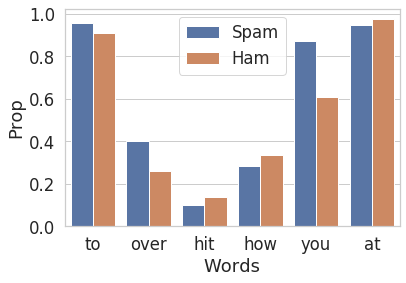

In [12]:
train=train.reset_index(drop=True) # We must do this in order to preserve the ordering of emails to labels for words_in_texts

words = ['to', 'over', 'hit', 'how', 'you', 'at']

spam,ham = train[train["spam"]==1],train[train["spam"]==0]

spam_match,ham_match = words_in_texts(words, spam['email']),words_in_texts(words, ham['email'])

spam_p,ham_p = [np.sum(x)/len(spam) for x in spam_match.T],[np.sum(x)/len(ham) for x in ham_match.T]

spam_and_ham_props = np.append(spam_p,ham_p)


dataf = {'Type': np.append(len(words) * ["Spam"],len(words) * ["Ham"]),
        'Words': words * 2,
        'Prop':spam_and_ham_props}
frame = pd.DataFrame(dataf)

sns.barplot(x = 'Words', y = 'Prop', hue=dataf['Type'], data=frame) 

When the feature is binary, it makes sense to compare its proportions across classes (as in the previous question). Otherwise, if the feature can take on numeric values, we can compare the distributions of these values for different classes. 

![training conditional densities](./images/training_conditional_densities2.png "Class Conditional Densities")


### Question 3b

Create a *class conditional density plot* like the one above (using `sns.distplot`), comparing the distribution of the length of spam emails to the distribution of the length of ham emails in the training set. Set the x-axis limit from 0 to 50000.

<!--
BEGIN QUESTION
name: q3b
manual: True
format: image
points: 2
-->
<!-- EXPORT TO PDF format:image -->

Text(0, 0.5, 'Distribution')

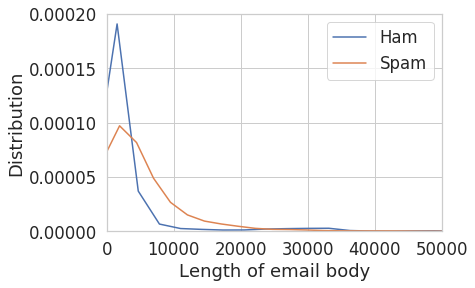

In [13]:
train=train.reset_index(drop=True)

spam = train[train["spam"]==1]
ham = train[train["spam"]==0]


sns.distplot(ham['email'].apply(len), label = 'Ham',hist=False)
sns.distplot(spam['email'].apply(len), label = 'Spam',hist=False) 

plt.xlim(0,50000)
plt.ylim(0,.0002)
plt.legend()
plt.xlabel('Length of email body')
plt.ylabel('Distribution')


# Basic Classification

Notice that the output of `words_in_texts(words, train['email'])` is a numeric matrix containing features for each email. This means we can use it directly to train a classifier!

### Question 4

We've given you 5 words that might be useful as features to distinguish spam/ham emails. Use these words as well as the `train` DataFrame to create two NumPy arrays: `X_train` and `Y_train`.

`X_train` should be a matrix of 0s and 1s created by using your `words_in_texts` function on all the emails in the training set.

`Y_train` should be a vector of the correct labels for each email in the training set.

*The provided tests check that the dimensions of your feature matrix (X) are correct, and that your features and labels are binary (i.e. consists of 0 and 1, no other values). It does not check that your function is correct; that was verified in a previous question.*
<!--
BEGIN QUESTION
name: q4
points: 2
-->

In [14]:
some_words = ['drug', 'bank', 'prescription', 'memo', 'private']

word_arr = words_in_texts(some_words, train['email'])
X_train = np.array(word_arr) 
Y_train = train['spam']

X_train[:5], Y_train[:5]

(array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0]]), 0    0
 1    0
 2    0
 3    0
 4    0
 Name: spam, dtype: int64)

In [15]:
ok.grade("q4");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 3
    Failed: 0
[ooooooooook] 100.0% passed



### Question 5

Now that we have matrices, we can use to scikit-learn! Using the [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier, train a logistic regression model using `X_train` and `Y_train`. Then, output the accuracy of the model (on the training data) in the cell below. You should get an accuracy around 0.75.

*The provided test checks that you initialized your logistic regression model correctly.*

<!--
BEGIN QUESTION
name: q5
points: 2
-->

In [16]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, Y_train)

training_accuracy = model.score(X_train, Y_train)
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.7576201251164648


In [17]:
ok.grade("q5");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



## Evaluating Classifiers

The classifier you made above isn't as good as this might lead us to believe. First, we are evaluating accuracy on the training set, which may provide a misleading accuracy measure, especially if we used the training set to identify discriminative features. In future parts of this analysis, it will be safer to hold out some of our data for model validation and comparison.

Presumably, our classifier will be used for **filtering**, i.e. preventing messages labeled `spam` from reaching someone's inbox. There are two kinds of errors we can make:
- False positive (FP): a ham email gets flagged as spam and filtered out of the inbox.
- False negative (FN): a spam email gets mislabeled as ham and ends up in the inbox.

Note that a true positive (TP) is a spam email that is classified as spam, and a true negative (TN) is a ham email that is classified as ham.

### Question 6a

Suppose we have a classifier `zero_predictor` that always predicts 0 (never predicts positive). How many false positives and false negatives would this classifier have if it were evaluated on the training set and its results were compared to `Y_train`? Fill in the variables below (answers can be hard-coded):

*Tests in Question 6 only check that you have assigned appropriate types of values to each response variable, but do not check that your answers are correct.*

<!--
BEGIN QUESTION
name: q6a
points: 1
-->

In [18]:
zero_predictor_fp = 0
zero_predictor_fn = (train[train['spam'] == 1]).shape[0]

In [19]:
ok.grade("q6a");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



### Question 6b

What are the accuracy and recall of `zero_predictor` (classifies every email as ham) on the training set? Do **NOT** use any `sklearn` functions.

<!--
BEGIN QUESTION
name: q6b
points: 1
-->

In [20]:
zero_predictor_acc = ((train[train['spam'] == 0 ]).shape[0])/((X_train).shape[0])
zero_predictor_recall = 0
zero_predictor_acc

0.7447091707706642

In [21]:
ok.grade("q6b");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



### Question 6c

Provide brief explanations of the results from 6a and 6b. Why do we observe each of these values (FP, FN, accuracy, recall)?

<!--
BEGIN QUESTION
name: q6c
manual: True
points: 2
-->
<!-- EXPORT TO PDF -->

*For 6a, there is 0 false positive because the zero predictor is always predicting 0 and therefore there can be no false positives. The false negatives are the amount of times that the email is classified as spam since the zero predictor always classifies emails as ham. Since the zero classfifier only predicts 0, there will be more false negatives (1918) than false positives (0) In addition, the amount of false negatives make up 25% of the training set.*

*For 6b, the zero predictor recall is 0. Recall refers to the amount of spam emails that were correctly flagged as spam so the recall is 0 since there is no way the zero predictor predict spam since it only classsfies emails as ham. The accuracy of the zero predictor is about 74%, this means 74% of the emails wre classfiied correctly. It also makes sense that the accuracy is around 74% since 25% of the training set is false negatives.*

### Question 6d

Compute the precision, recall, and false-alarm rate of the `LogisticRegression` classifier created and trained in Question 5. Do **NOT** use any `sklearn` functions.

<!--
BEGIN QUESTION
name: q6d
points: 2
-->

In [22]:
preds = model.predict(X_train)

TRUE_NEG =np.count_nonzero(~preds & ~Y_train)
TRUE_POS = np.count_nonzero(preds & Y_train)
FALSE_POS = np.count_nonzero(preds & ~Y_train)
FALSE_NEG = np.count_nonzero(~preds & Y_train)

logistic_predictor_precision = (TRUE_POS)/(TRUE_POS+FALSE_POS)
logistic_predictor_recall = (TRUE_POS)/(TRUE_POS+FALSE_NEG)
logistic_predictor_far = (FALSE_POS)/(FALSE_POS+TRUE_NEG)
logistic_predictor_precision
logistic_predictor_recall
logistic_predictor_far

0.015979043876882777

In [23]:
ok.grade("q6d");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 3
    Failed: 0
[ooooooooook] 100.0% passed



### Question 6e

Are there more false positives or false negatives when using the logistic regression classifier from Question 5?

<!--
BEGIN QUESTION
name: q6e
manual: True
points: 1
-->
<!-- EXPORT TO PDF -->

*There are more false negatives than false positives when using the logistic regression clasifier from Question 5. There are 1699 false negatives and only 122 false positives.*

### Question 6f

1. Our logistic regression classifier got 75.6% prediction accuracy (number of correct predictions / total). How does this compare with predicting 0 for every email?
1. Given the word features we gave you above, name one reason this classifier is performing poorly. Hint: Think about how prevalent these words are in the email set.
1. Which of these two classifiers would you prefer for a spam filter and why? Describe your reasoning and relate it to at least one of the evaluation metrics you have computed so far.

<!--
BEGIN QUESTION
name: q6f
manual: True
points: 3
-->
<!-- EXPORT TO PDF -->

*1. Our logistic regression classifier got 75.6% prediction accuracy whereas our zero predictor classfier has a 74.4% accuracy. Therefore, our logistic regression classifier is more accurate/has a higher accuracy than our zero predictor classifier.*

*2. One reason the classifier is performing poorly is because the words are prevalent in both spam and ham emails. The words are not very specific to spam emails and so they are words that could be found widely across both spam and ham emails.*

*3. Of these two classifiers, I would prefer our logistic regression classifier because it has a slightly higher predicition accuracy. It's also trained with our data and uses X_train and Y_train. In addition, the accuracy calculated with our logistic regression classifier is higher than than of the zero predictor classfier (75.6% vs 74.4%). With a zero predictor clasfier, we will not catch any spam emails since we are prediciting every email to be non-spam.*

# Part II - Moving Forward

With this in mind, it is now your task to make the spam filter more accurate. In order to get full credit on the accuracy part of this assignment, you must get at least **88%** accuracy on the test set. To see your accuracy on the test set, you will use your classifier to predict every email in the `test` DataFrame and upload your predictions to Kaggle.


---

In [24]:
#Method 1: creating functions to make spam filter more accurate

#number of characters of subject
def num_char(d):
    d['num char email'] = d['email'].str.len()
    d['num char subject'] = d['subject'].str.len()
    return d

#number of words of email and subject
def num_words(d):
    d['num words email'] = d['email'].str.split().str.len()
    d['num words subject'] = d['subject'].str.split().str.len()
    return d


#number of special char of email and subject
def num_special_char(d):
    d['num special char email'] = d['email'].str.findall('[@_!#$%^&*()<>?/\|}{~:]').str.len()
    d['num special char subject'] = d['subject'].str.findall('[@_!#$%^&*()<>?/\|}{~:]').str.len()
    return d

#number of email and subject
def num_less_and_greater_than(d):
    d['num < email'] = d['email'].str.findall('<').str.len()
    d['num > email'] = d['email'].str.findall('>').str.len()
    d['num < subject'] = d['subject'].str.findall('<').str.len()
    d['num > subject'] = d['subject'].str.findall('>').str.len()
    return d

#prop of caps email and subject
def capital_prop(d):
    d['prop lowercase email'] = d['email'].str.findall('[A-Z]').str.len() / d['email'].str.findall('[a-zA-Z]').str.len()
    d['prop lowercase subject'] = d['subject'].str.findall('[A-Z]').str.len() / d['email'].str.findall('[a-zA-Z]').str.len()
    return d

#prop of lower email and subject
def lower_prop(d):
    d['prop capital email'] = d['email'].str.findall('a-zA-Z]').str.len() / d['email'].str.findall('[A-Z]').str.len()
    d['prop capital subject'] = d['subject'].str.findall('a-zA-Z]').str.len() / d['subject'].str.findall('[A-Z]').str.len()
    return d

In [25]:
#Method 2: Using 4 different lists of words to create a more accurate spam filter
#Following through with Method 2, which produced a higher accuracy than Method 1

from sklearn.linear_model import LogisticRegression
words1 = ['%','$','100%', 'new', 'ad', 'free', 'money','earn','debt','make','*'
         'price','=', 'ã','act', 'now', 'click', 'cash', '>', '<','html', '--', '!','@','_']
words2 = ['omg','shipping!','today!','here!','online!','available!','#1','all new', 'bargain',
         'best price','bonus','cost','credit','delete','50% off', 'off', 'brand','satisfied',
         '100% satisfied','claims','selling','costs','discount',"don't delete",'f r e e']
words3 = ['fast cash', 'for free', '100% free', '(',')',':','!!','action','$$$','4U','act now',
         'billion','bill','billing','call','bank','bankruptcy','cheap','collect','earn','extra','fast',
          'for you','free money','free trial', '!!']
words4 = ['please read', 'winner','winning','only $', 'one hundred','supplies last','viagra',
         'earn per week','no strings attached','urgent','dollars','debit','do it today',
         'no fees','no cost','prize','supplies are limited','click here','click below','click to',
         'click','no claim','scam','gimmick','scheme','promise','free gift', 'first', 'love',
         'save', 'take', 'off', '100% more', 'additional income', 'be your own boss', 'best price',
         'big bucks','cash bonus','consolidate debt','double','eliminate bad credit', 'extra cash',
         'extra income', 'financial freedom','ged paid','guaranteed','giveaway','increases sales',
         'free quote','lowest price','miracle','money back']
def refined_words_in_texts(words, texts):
    words = words+words1+words2+words3+words4
    match = [(x in y) for y in texts for x in words]
    match = np.array(match).astype(int) 
    length = len(texts)
    arrs = np.hsplit(np.array(match), length)
    indicator_array = np.array(arrs)
    return indicator_array


#all_words = words1+words2+words3+words4
a = train.copy()

word_arr = refined_words_in_texts(words, a['email'])
X_train = np.array(word_arr) 
Y_train = a['spam']

TEST = test.copy()
TEST_word_arr = refined_words_in_texts(words, TEST['email'])
X_TEST_TRAIN = np.array(TEST_word_arr)


refined_model = LogisticRegression()
refined_model.fit(X_train, Y_train)

training_accuracy = refined_model.score(X_train, Y_train)
training_accuracy

0.9202715293491281

### Question 7: Feature/Model Selection Process

In this following cell, describe the process of improving your model. You should use at least 2-3 sentences each to address the follow questions:

1. How did you find better features for your model?
2. What did you try that worked / didn't work?
3. What was surprising in your search for good features?

<!--
BEGIN QUESTION
name: q7
manual: True
points: 6
-->
<!-- EXPORT TO PDF -->

*1. I found better features for my model by looking at the content of spam emails. By doing so, I saw that many spam emails included special characters (like !) and repetition of special characters or uppercase letters. I also found better features for my model by looking at the content of the spam emails and noticing that many of the spam emails were geared toward topics of selling or finance, therefore containing strings like "free"  and "%".*

*2. What I tried that did not work was comparing the number of words between spam and ham emails. Through this comparison I did not find a significant relationship and there was no pattern found. What I did found that worked was including special characters as something to look for in spam emails. I made sure to incorporate differnt types of special characters in my words to find list as special characters seems to be very prevalent and repeated in spam emails.*

*3. Something surprising in my search for good features was that spam and ham emails did not have a significant relationship in regards to the number of chracters or words. I thought spam emails would contain significantly less words and characters than ham emails but there was not a significant pattern/difference in the number. I was surpised to not find a significant relationship between the number of words/characters between spam and ham emails.*

### Question 8: EDA

In the cell below, show a visualization that you used to select features for your model. Include

1. A plot showing something meaningful about the data that helped you during feature selection, model selection, or both.
2. Two or three sentences describing what you plotted and its implications with respect to your features.

Feel to create as many plots as you want in your process of feature selection, but select one for the response cell below.

Generate your visualization in the cell below and provide your description in a comment.

<!--
BEGIN QUESTION
name: q8
manual: True
format: image
points: 6
-->
<!-- EXPORT TO PDF format:image -->

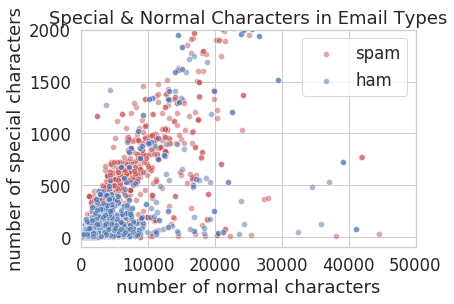

In [26]:
# Write your description (2-3 sentences) as a comment here:
# I made a scatter plot comparing the number of special characters versus the number of characters for both 
#ham and spam emails. I distinguished between spam and ham emails through the use of colors to show this 
#relationship, red being spam points and blue being ham points. As you can see, most of the ham data 
#points are clustered at the bottom left of the graph whereas the spam data points are scattered upwards 
#and have a greater number of special characters. It is evident that for the most part,spam emails tend 
#to have a greater number of special characters than ham emails. It appears that most ham emails have at 
#most 500 special characters whereas a significant number spam emails appear to have much more than 500 
#special characters. In conclusion, the graph illustrates that spam emails have more special characters 
#than ham emails. 

# Write the code to generate your visualization here:
tr=train.reset_index(drop=True) 
spam = tr[tr["spam"]==1]
ham = tr[tr["spam"]==0]

tr['spam special char'] = spam['email'].str.count('[|@|_|!|#|$|%|^|&|*|(|)|<|>|?|/|\|}|{|~|:|]')
tr['ham special char'] = ham['email'].str.count('[|@|_|!|#|$|%|^|&|*|(|)|<|>|?|/|\|}|{|~|:|]')
tr['spam char'] = spam['email'].str.len()
tr['ham char'] = ham['email'].str.len()

tr = tr.replace('nan', np.nan).fillna(0)

spamdf = tr.query("spam >0")
hamdf = tr.query("spam == 0")

sns.scatterplot(x="spam char", y="spam special char", data=spamdf,alpha=.5,color = 'r');
sns.scatterplot(x="ham char", y="ham special char", data=hamdf, alpha=.5,color = 'b');
plt.xlabel('number of normal characters')
plt.ylabel('number of special characters')
plt.title('Special & Normal Characters in Email Types')

plt.xlim(-100,50000)
plt.ylim(-100,2000)
plt.legend(labels=['spam', 'ham'])



### Question 9: ROC Curve

In most cases we won't be able to get no false positives and no false negatives, so we have to compromise. For example, in the case of cancer screenings, false negatives are comparatively worse than false positives — a false negative means that a patient might not discover a disease until it's too late to treat, while a false positive means that a patient will probably have to take another screening.

Recall that logistic regression calculates the probability that an example belongs to a certain class. Then, to classify an example we say that an email is spam if our classifier gives it $\ge 0.5$ probability of being spam. However, *we can adjust that cutoff*: we can say that an email is spam only if our classifier gives it $\ge 0.7$ probability of being spam, for example. This is how we can trade off false positives and false negatives.

The ROC curve shows this trade off for each possible cutoff probability. In the cell below, plot an ROC curve for your final classifier (the one you use to make predictions for Kaggle). Refer to the Lecture 22 notebook or Section 17.7 of the course text to see how to plot an ROC curve.



<!--
BEGIN QUESTION
name: q9
manual: True
points: 3
-->
<!-- EXPORT TO PDF -->

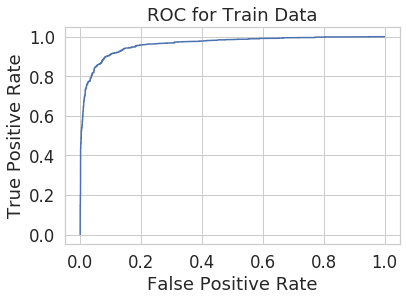

In [27]:
from sklearn.metrics import roc_curve

probabilities = refined_model.predict_proba(X_train) 
predictions = probabilities[:,1]
fp_rate, tp_rate, threshold = roc_curve(Y_train, predictions) 


plt.plot(fp_rate, tp_rate, 'b')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Train Data')
plt.show()



# Question 10: Submitting to Kaggle

The following code will write your predictions on the test dataset to a CSV, which you can submit to Kaggle. You may need to modify it to suit your needs.

Save your predictions in a 1-dimensional array called `test_predictions`. *Even if you are not submitting to Kaggle, please make sure you've saved your predictions to `test_predictions` as this is how your score for this question will be determined.*

Remember that if you've performed transformations or featurization on the training data, you must also perform the same transformations on the test data in order to make predictions. For example, if you've created features for the words "drug" and "money" on the training data, you must also extract the same features in order to use scikit-learn's `.predict(...)` method.

You should submit your CSV files to https://www.kaggle.com/c/ds100fa19

*The provided tests check that your predictions are in the correct format, but you must submit to Kaggle to evaluate your classifier accuracy.*

<!--
BEGIN QUESTION
name: q10
points: 15
-->

In [28]:
test_predictions = refined_model.predict(X_TEST_TRAIN)

In [29]:
ok.grade("q10");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 3
    Failed: 0
[ooooooooook] 100.0% passed



The following saves a file to submit to Kaggle.

In [30]:
from datetime import datetime

# Assuming that your predictions on the test set are stored in a 1-dimensional array called
# test_predictions. Feel free to modify this cell as long you create a CSV in the right format.

# Construct and save the submission:
submission_df = pd.DataFrame({
    "Id": test['id'], 
    "Class": test_predictions,
}, columns=['Id', 'Class'])
timestamp = datetime.isoformat(datetime.now()).split(".")[0]
submission_df.to_csv("submission_{}.csv".format(timestamp), index=False)

print('Created a CSV file: {}.'.format("submission_{}.csv".format(timestamp)))
print('You may now upload this CSV file to Kaggle for scoring.')

Created a CSV file: submission_2019-12-08T19:27:04.csv.
You may now upload this CSV file to Kaggle for scoring.


# Submit
Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output.
**Please save before submitting!**

<!-- EXPECT 9 EXPORTED QUESTIONS -->

In [ ]:
# Save your notebook first, then run this cell to submit.
import jassign.to_pdf
jassign.to_pdf.generate_pdf('proj2.ipynb', 'proj2.pdf')
ok.submit()

Generating PDF...
Saved proj2.pdf


<IPython.core.display.Javascript object>